<a href="https://colab.research.google.com/github/ErangaOttachchige/Classify-traffic-congestion-level-using-MLP-with-PyTorch/blob/main/Classify_traffic_congestion_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup and imports

In [ ]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


2. Load dataset inside the notebook (UCI source)

In [ ]:
# UCI dataset reference:
# Metro Interstate Traffic Volume (Hogue, 2019), DOI: 10.24432/C5X60B
# Dataset file (CSV.GZ) is listed on the UCI dataset page.

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"
LOCAL_PATH = "Metro_Interstate_Traffic_Volume.csv.gz"

if not os.path.exists(LOCAL_PATH):
    print("Downloading dataset from UCI...")
    urllib.request.urlretrieve(DATA_URL, LOCAL_PATH)
    print("Download complete:", LOCAL_PATH)
else:
    print("Dataset already exists locally:", LOCAL_PATH)

df = pd.read_csv(LOCAL_PATH, compression="gzip")
print("Shape:", df.shape)
df.head()


Download complete: Metro_Interstate_Traffic_Volume.csv.gz
Shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


3. Data cleaning + feature engineering (datetime → hour, weekday, month, weekend)

In [ ]:
# Basic checks
print(df.columns)
print(df.isna().sum())

# Parse datetime (local CST per UCI documentation)
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

# Drop rows with invalid datetimes (should be rare)
df = df.dropna(subset=["date_time"]).reset_index(drop=True)

# Feature engineering from datetime
df["hour"] = df["date_time"].dt.hour
df["weekday"] = df["date_time"].dt.weekday  # Monday=0 ... Sunday=6
df["month"] = df["date_time"].dt.month
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

df.head()


Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,weekday,month,is_weekend
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,1,10,0
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,1,10,0
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,1,10,0
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,1,10,0
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,1,10,0


4. Create 3-class target using quantiles (Low / Medium / High)

In [ ]:
# Convert continuous traffic_volume into 3 balanced classes via quantiles
labels = ["Low", "Medium", "High"]

# Robust qcut: if duplicate edges occur, fall back to cut.
try:
    df["congestion_class"] = pd.qcut(df["traffic_volume"], q=[0, 1/3, 2/3, 1], labels=labels)
except ValueError:
    # Fallback: equal-width bins (less balanced, but ensures code runs)
    df["congestion_class"] = pd.cut(df["traffic_volume"], bins=3, labels=labels)

# Confirm class distribution
print(df["congestion_class"].value_counts(dropna=False))


congestion_class
Low       16070
Medium    16067
High      16067
Name: count, dtype: int64


5. Define features (X) and target (y)

In [ ]:
# Features selected (mixed numeric + categorical + engineered time features)
numeric_features = ["temp", "rain_1h", "snow_1h", "clouds_all", "hour", "weekday", "month", "is_weekend"]
categorical_features = ["holiday", "weather_main", "weather_description"]

X = df[numeric_features + categorical_features].copy()
y = df["congestion_class"].astype(str).copy()  # keep as string labels for sklearn; later encode for PyTorch


6. Train/validation/test split (stratified)

In [ ]:
# 80/20 train-test split, stratified to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Split training further into train/validation (80/20 of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Val class distribution:\n", y_val.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train: (30850, 11) Val: (7713, 11) Test: (9641, 11)
Train class distribution:
 congestion_class
Low       0.333387
Medium    0.333323
High      0.333290
Name: proportion, dtype: float64
Val class distribution:
 congestion_class
Medium    0.333333
High      0.333333
Low       0.333333
Name: proportion, dtype: float64
Test class distribution:
 congestion_class
High      0.333368
Low       0.333368
Medium    0.333264
Name: proportion, dtype: float64


7. Preprocessing pipeline (impute + one-hot encode + scale)

In [ ]:
# Numeric pipeline: median imputation + standard scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: impute "None" + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['temp', 'rain_1h', 'snow_1h', 'clouds_all',
                                  'hour', 'weekday', 'month', 'is_weekend']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='None',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['holiday', 'weather_main',
                                  'weather_description'])])

8. Baseline models (recommended for stronger marks)
8.1.  Baseline 1: SVM (scikit-learn)

In [ ]:
svm_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", SVC(kernel="rbf", C=5.0, gamma="scale", probability=True, random_state=42))
])

svm_model.fit(X_train, y_train)

svm_val_pred = svm_model.predict(X_val)
print("SVM Validation Classification Report")
print(classification_report(y_val, svm_val_pred))


SVM Validation Classification Report
              precision    recall  f1-score   support

        High       0.81      0.86      0.83      2571
         Low       0.96      0.94      0.95      2571
      Medium       0.80      0.77      0.78      2571

    accuracy                           0.86      7713
   macro avg       0.86      0.86      0.86      7713
weighted avg       0.86      0.86      0.86      7713



8.2 Baseline 2: Random Forest (scikit-learn)

In [ ]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

rf_val_pred = rf_model.predict(X_val)
print("Random Forest Validation Classification Report")
print(classification_report(y_val, rf_val_pred))


Random Forest Validation Classification Report
              precision    recall  f1-score   support

        High       0.86      0.90      0.88      2571
         Low       0.96      0.93      0.94      2571
      Medium       0.83      0.82      0.83      2571

    accuracy                           0.88      7713
   macro avg       0.88      0.88      0.88      7713
weighted avg       0.88      0.88      0.88      7713



8.3 Baseline visualisation: Confusion matrices (Val)

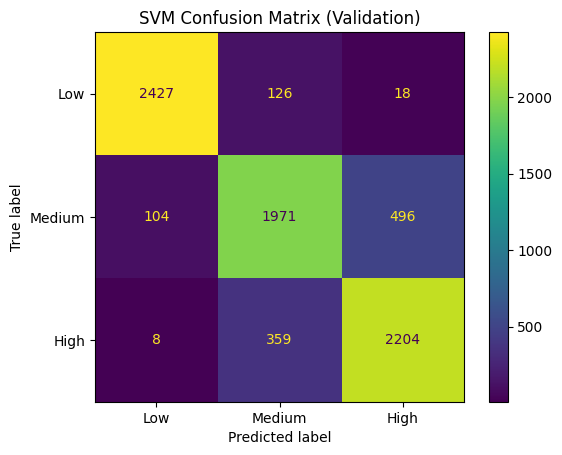

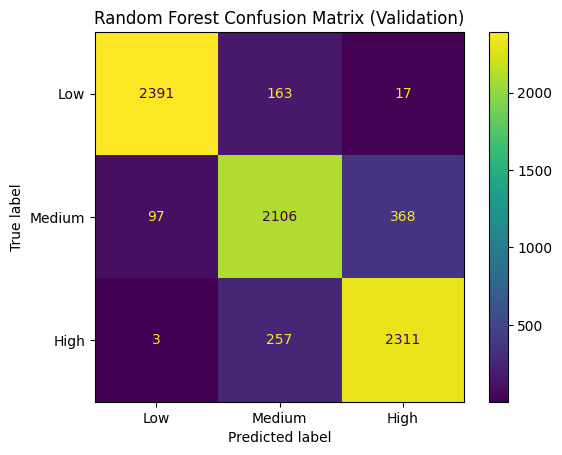

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()

plot_cm(y_val, svm_val_pred, "SVM Confusion Matrix (Validation)")
plot_cm(y_val, rf_val_pred, "Random Forest Confusion Matrix (Validation)")


9. MLP implementation in depth (PyTorch) — selected technique for Part C
9.1 Prepare data for PyTorch (fit preprocessing on train, transform all splits)

In [ ]:
# Fit the preprocessing pipeline on training data only (prevents data leakage)
preprocessor.fit(X_train)

X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

# Convert sparse matrices (from one-hot) to dense arrays for PyTorch
def to_dense(matrix):
    return matrix.toarray() if hasattr(matrix, "toarray") else np.asarray(matrix)

X_train_np = to_dense(X_train_t).astype(np.float32)
X_val_np   = to_dense(X_val_t).astype(np.float32)
X_test_np  = to_dense(X_test_t).astype(np.float32)

# Encode labels: Low=0, Medium=1, High=2
label_to_id = {lab: i for i, lab in enumerate(labels)}
y_train_np = np.array([label_to_id[v] for v in y_train], dtype=np.int64)
y_val_np   = np.array([label_to_id[v] for v in y_val], dtype=np.int64)
y_test_np  = np.array([label_to_id[v] for v in y_test], dtype=np.int64)

input_dim = X_train_np.shape[1]
num_classes = 3
print("Input dimension:", input_dim)


Input dimension: 68


9.2 DataLoaders

In [ ]:
BATCH_SIZE = 256

train_ds = TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np))
val_ds   = TensorDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np))
test_ds  = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


9.3 Define the MLP model

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
model


MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

9.4 Training setup (loss, optimizer)

In [ ]:
# CrossEntropyLoss is appropriate for multi-class classification with logits
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


9.5 Training loop (with validation + early stopping)

In [ ]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

EPOCHS = 40
PATIENCE = 6  # early stopping patience

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_loss = float("inf")
best_state = None
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    train_losses = []
    train_accs = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy_from_logits(logits, yb))

    # ---- Validate ----
    model.eval()
    val_losses = []
    val_accs = []
    with torch.inference_mode():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_losses.append(loss.item())
            val_accs.append(accuracy_from_logits(logits, yb))

    train_loss = float(np.mean(train_losses))
    val_loss = float(np.mean(val_losses))
    train_acc = float(np.mean(train_accs))
    val_acc = float(np.mean(val_accs))

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | Train Loss: 0.8430 Acc: 0.6681 | Val Loss: 0.6295 Acc: 0.7639
Epoch 02 | Train Loss: 0.5439 Acc: 0.7788 | Val Loss: 0.4716 Acc: 0.8245
Epoch 03 | Train Loss: 0.4572 Acc: 0.8189 | Val Loss: 0.4279 Acc: 0.8506
Epoch 04 | Train Loss: 0.4253 Acc: 0.8301 | Val Loss: 0.4028 Acc: 0.8465
Epoch 05 | Train Loss: 0.4011 Acc: 0.8408 | Val Loss: 0.3831 Acc: 0.8568
Epoch 06 | Train Loss: 0.3886 Acc: 0.8456 | Val Loss: 0.3717 Acc: 0.8619
Epoch 07 | Train Loss: 0.3744 Acc: 0.8524 | Val Loss: 0.3590 Acc: 0.8645
Epoch 08 | Train Loss: 0.3653 Acc: 0.8536 | Val Loss: 0.3452 Acc: 0.8705
Epoch 09 | Train Loss: 0.3571 Acc: 0.8575 | Val Loss: 0.3387 Acc: 0.8687
Epoch 10 | Train Loss: 0.3500 Acc: 0.8626 | Val Loss: 0.3322 Acc: 0.8753
Epoch 11 | Train Loss: 0.3425 Acc: 0.8667 | Val Loss: 0.3282 Acc: 0.8730
Epoch 12 | Train Loss: 0.3352 Acc: 0.8677 | Val Loss: 0.3212 Acc: 0.8758
Epoch 13 | Train Loss: 0.3341 Acc: 0.8683 | Val Loss: 0.3169 Acc: 0.8795
Epoch 14 | Train Loss: 0.3332 Acc: 0.8688 | Val Los

9.6 Visualisation 1: Loss curve (train vs validation)

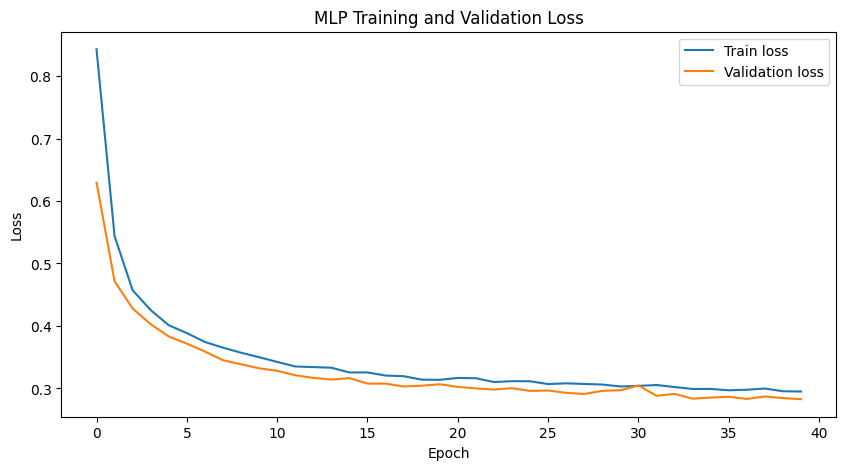

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training and Validation Loss")
plt.legend()
plt.show()


9.7 Evaluation on the test set (classification report + confusion matrix)

MLP Test Classification Report
              precision    recall  f1-score   support

         Low       0.85      0.92      0.88      3214
      Medium       0.95      0.94      0.95      3214
        High       0.86      0.80      0.83      3213

    accuracy                           0.89      9641
   macro avg       0.89      0.89      0.89      9641
weighted avg       0.89      0.89      0.89      9641



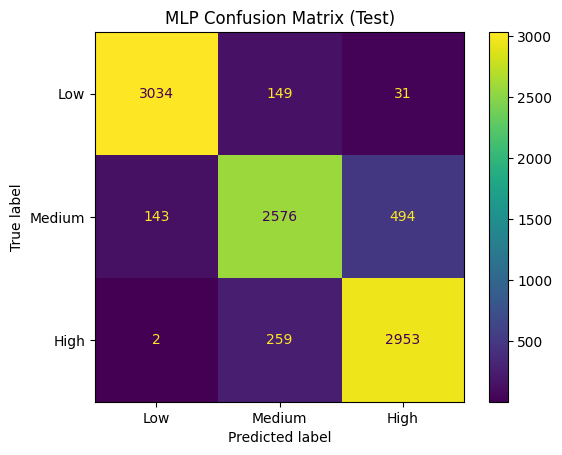

In [ ]:
# Collect predictions on test set
model.eval()
all_logits = []
all_true = []

with torch.inference_mode():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).cpu()
        all_logits.append(logits)
        all_true.append(yb)

all_logits = torch.cat(all_logits, dim=0)
all_true = torch.cat(all_true, dim=0)

test_preds = torch.argmax(all_logits, dim=1).numpy()
test_true = all_true.numpy()

# Convert back to label names for reporting
id_to_label = {v: k for k, v in label_to_id.items()}
test_pred_labels = [id_to_label[i] for i in test_preds]
test_true_labels = [id_to_label[i] for i in test_true]

print("MLP Test Classification Report")
print(classification_report(test_true_labels, test_pred_labels, target_names=labels))

plot_cm(test_true_labels, test_pred_labels, "MLP Confusion Matrix (Test)")


10. “Most influential features” analysis (RF baseline)

Because MLPs are less directly interpretable, a practical approach is to use a strong baseline model (RF) to provide insight into which engineered/context features matter most. Here, permutation importance is computed on the validation set to estimate which input features contribute most to predictive performance.

In [ ]:
from sklearn.inspection import permutation_importance

# Fit RF pipeline on combined train+val for a stable baseline explanation
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

rf_model.fit(X_trainval, y_trainval)

# Permutation importance on the *full pipeline* using raw X_val
result = permutation_importance(
    rf_model,           # <-- pipeline (preprocess + RF)
    X_val,              # <-- raw validation data (NOT transformed)
    y_val,              # <-- raw labels (NOT encoded)
    n_repeats=5,
    random_state=42,
    scoring="accuracy"
)

importances = result.importances_mean

# NOTE: Feature names come from the fitted preprocessor inside the pipeline
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

top_idx = np.argsort(importances)[::-1][:15]

top_features = pd.DataFrame({
    "feature": feature_names[top_idx],
    "importance_mean": importances[top_idx]
}).reset_index(drop=True)

top_features

In [ ]:
# Plot top 15 permutation importances
plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"][::-1], top_features["importance_mean"][::-1])
plt.xlabel("Mean importance (accuracy decrease)")
plt.title("Top 15 Most Influential Features (RF Permutation Importance)")
plt.show()


11. Predict a new sample (end-to-end: raw input → preprocessing → MLP → probabilities)

In [ ]:
def predict_congestion(sample: dict):
    """
    sample example:
    {
      "date_time": "2018-09-30 17:00:00",
      "holiday": "None",
      "temp": 295.1,
      "rain_1h": 0.0,
      "snow_1h": 0.0,
      "clouds_all": 90,
      "weather_main": "Clouds",
      "weather_description": "overcast clouds"
    }
    """
    s = sample.copy()
    s["date_time"] = pd.to_datetime(s["date_time"], errors="coerce")
    if pd.isna(s["date_time"]):
        raise ValueError("Invalid date_time in sample.")

    # Engineer time features
    s["hour"] = s["date_time"].hour
    s["weekday"] = s["date_time"].weekday()
    s["month"] = s["date_time"].month
    s["is_weekend"] = int(s["weekday"] >= 5)

    # Build a one-row dataframe in the same format as training
    row = pd.DataFrame([{
        "temp": s.get("temp", np.nan),
        "rain_1h": s.get("rain_1h", np.nan),
        "snow_1h": s.get("snow_1h", np.nan),
        "clouds_all": s.get("clouds_all", np.nan),
        "hour": s["hour"],
        "weekday": s["weekday"],
        "month": s["month"],
        "is_weekend": s["is_weekend"],
        "holiday": s.get("holiday", "None"),
        "weather_main": s.get("weather_main", "None"),
        "weather_description": s.get("weather_description", "None")
    }])

    # Preprocess using already-fitted preprocessor
    x = preprocessor.transform(row)
    x = to_dense(x).astype(np.float32)
    x_t = torch.from_numpy(x).to(device)

    # MLP inference
    model.eval()
    with torch.inference_mode():
        logits = model(x_t).cpu()
        probs = torch.softmax(logits, dim=1).numpy().flatten()

    pred_id = int(np.argmax(probs))
    pred_label = id_to_label[pred_id]
    return pred_label, probs

# Example prediction
example_sample = {
    "date_time": "2018-10-01 08:00:00",
    "holiday": "None",
    "temp": 285.5,
    "rain_1h": 0.0,
    "snow_1h": 0.0,
    "clouds_all": 75,
    "weather_main": "Clouds",
    "weather_description": "broken clouds"
}

pred_label, probs = predict_congestion(example_sample)
print("Predicted class:", pred_label)
print("Probabilities [Low, Medium, High]:", probs)
